In [1]:
import sys, os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import pickle
from pathlib import Path

In [2]:

ROOT = Path.cwd().parents[0]
model_name="xgboost_panel_with_feat"
FEATURE_LIST_FILE = ROOT / "datamodel" / f"{model_name}.pkl"
MODEL_FILE = ROOT / "datamodel" / f"{model_name}.pkl"
RESULT_FILE = ROOT / 'datamodel' / f"{model_name}_pred.csv"
ENCODER_FILE  = ROOT / "datamodel" / f"{model_name}_label_enc.pkl"

In [3]:
from pathlib import Path
import geopandas as gpd

ROOT = Path.cwd().parents[0]
GEOJSON_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
print("[Path exists?]", GEOJSON_FILE.exists(), "➜", GEOJSON_FILE)

zones_gdf = gpd.read_file(GEOJSON_FILE)
print(zones_gdf.columns)


[Path exists?] True ➜ c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datasets\raw\boroughs_montreal.geojson
Index(['CODEID', 'NOM', 'NOM_OFFICIEL', 'CODEMAMH', 'CODE_3C', 'NUM', 'ABREV',
       'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')


In [4]:
df=pd.read_csv(RESULT_FILE)

C:\Users\mirei\AppData\Local\Temp\ipykernel_27808\3231598741.py:33: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


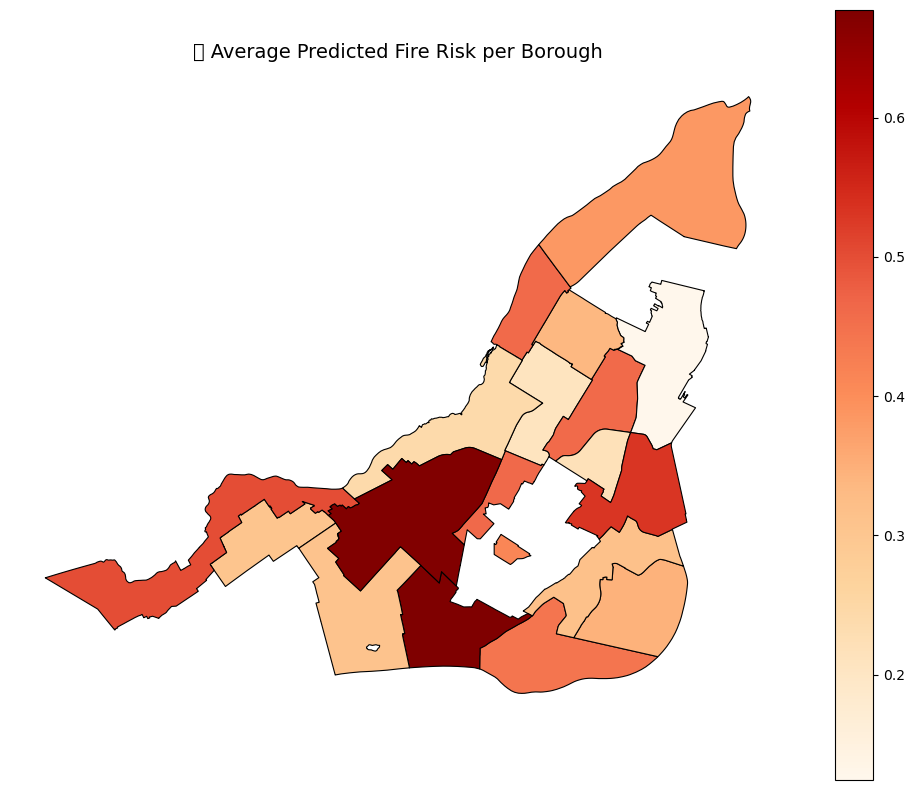

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 🔹 Load boroughs GeoJSON
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
zones_gdf = gpd.read_file(boroughs_path)

# 🔹 Create code → name mapping
code_to_name = dict(zip(zones_gdf["CODEID"], zones_gdf["NOM"]))

# 🔹 Replace numeric code with readable borough name
df["BOROUGH_NAME"] = df["NO_ARROND_ILE_CUM"].map(code_to_name)

# 🔹 Aggregate average predicted fire probability per borough
agg = df.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# 🔹 Merge with borough geometry for mapping
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg, on="BOROUGH_NAME", how="left")

# 🔹 Plot
fig, ax = plt.subplots(figsize=(10, 8))
map_df.plot(
    column="predicted_proba", 
    cmap="OrRd", 
    linewidth=0.8, 
    edgecolor="black", 
    legend=True, 
    ax=ax
)
ax.set_title("🔥 Average Predicted Fire Risk per Borough", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()


In [6]:
print("📌 NO_ARROND_ILE_CUM → BOROUGH_NAME mapping:")
print(df[["NO_ARROND_ILE_CUM", "BOROUGH_NAME"]].drop_duplicates().sort_values("NO_ARROND_ILE_CUM"))


📌 NO_ARROND_ILE_CUM → BOROUGH_NAME mapping:
         NO_ARROND_ILE_CUM                              BOROUGH_NAME
1452216                  0                                       NaN
590796                   1                                    Dorval
12660                    2                                 Hampstead
920844                   3                       Dollard-des-Ormeaux
2091696                  4                                    Verdun
826788                   5                       Pierrefonds-Roxboro
2128536                  6                             Saint-Léonard
0                        7                             Saint-Laurent
18516                    8                             Montréal-Nord
72                       9                                   Lachine
372900                  10                                   LaSalle
1324884                 11  Rivière-des-Prairies-Pointe-aux-Trembles
508572                  12                                M

Buildings missing borough name after spatial join: 0


C:\Users\mirei\AppData\Local\Temp\ipykernel_27808\536397634.py:55: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
c:\ProgramData\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


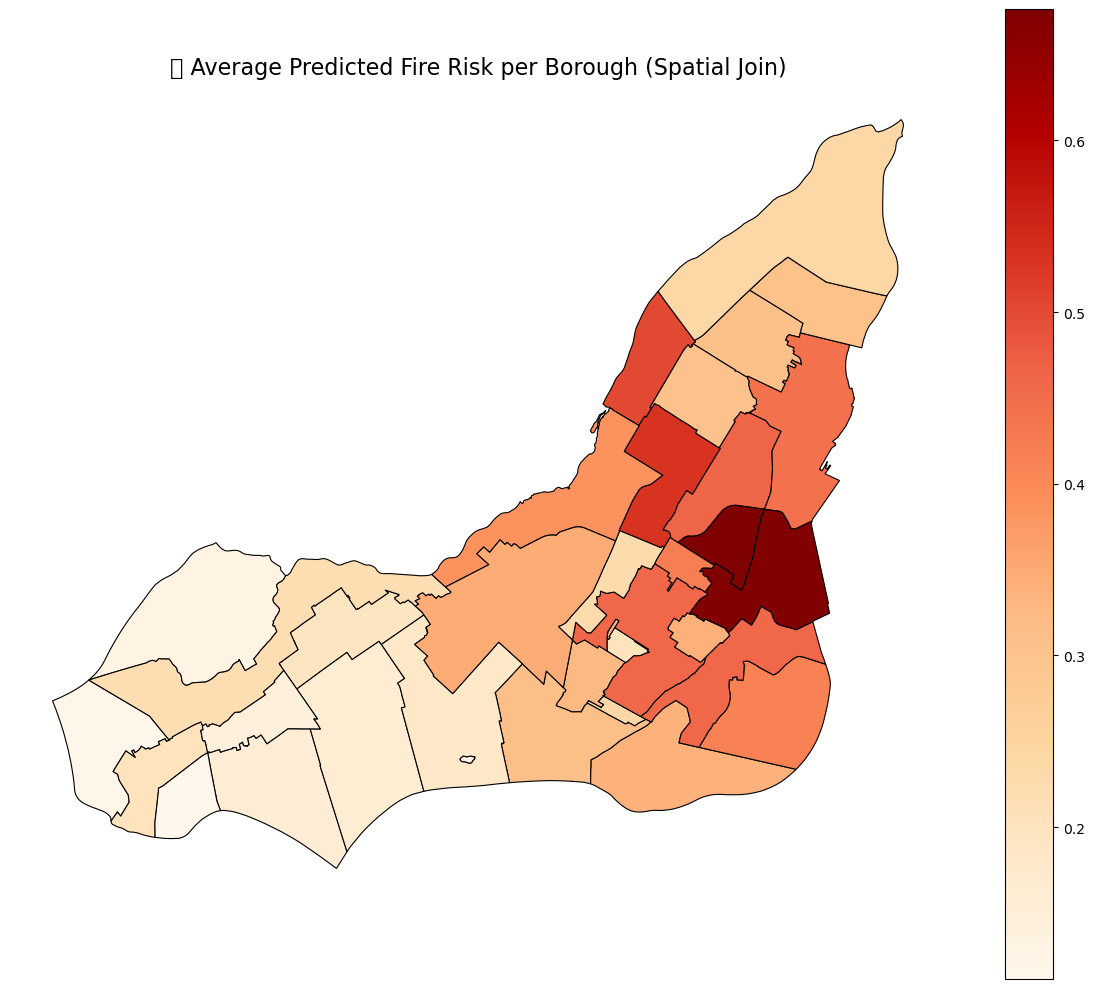

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pathlib import Path

# Paths
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
BOROUGH_FILE = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"

# Load prediction data
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "NO_ARROND_ILE_CUM", "LATITUDE", "LONGITUDE", "predicted_proba"])

# Drop rows with missing coords or predicted prob
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])

# Convert prediction df to GeoDataFrame with points
geometry = gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"])
buildings_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Load borough shapefile and reproject to EPSG:4326 if needed
zones_gdf = gpd.read_file(BOROUGH_FILE)
if zones_gdf.crs != buildings_gdf.crs:
    zones_gdf = zones_gdf.to_crs(buildings_gdf.crs)

# Spatial join: assign borough name by point location
buildings_with_borough = gpd.sjoin(buildings_gdf, zones_gdf[["CODEID", "NOM", "geometry"]], how="left", predicate="within")
buildings_with_borough = buildings_with_borough.rename(columns={"NOM": "BOROUGH_NAME"})

# Check missing boroughs after join
missing_boroughs_count = buildings_with_borough["BOROUGH_NAME"].isna().sum()
print(f"Buildings missing borough name after spatial join: {missing_boroughs_count}")

# Aggregate average predicted fire risk by borough
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()

# Merge aggregated risk with borough polygons for plotting
zones_gdf["BOROUGH_NAME"] = zones_gdf["NOM"]
map_df = zones_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# Plot map
fig, ax = plt.subplots(figsize=(12, 10))
map_df.plot(
    column="predicted_proba",
    cmap="OrRd",
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey", "label": "No data"}
)
ax.set_title("🔥 Average Predicted Fire Risk per Borough (Spatial Join)", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()


In [18]:
# Check columns in zones_gdf
print(zones_gdf.columns)


Index(['CODEID', 'BOROUGH_NAME', 'NOM_OFFICIEL', 'CODEMAMH', 'CODE_3C', 'NUM',
       'ABREV', 'TYPE', 'COMMENT', 'DATEMODIF', 'geometry'],
      dtype='object')


In [19]:
import geopandas as gpd

# zones_gdf is your borough shapefile GeoDataFrame
# buildings_gdf is your buildings GeoDataFrame with points (longitude/latitude)

# Ensure CRS matches
zones_gdf = zones_gdf.to_crs("EPSG:4326")

buildings_with_borough = gpd.sjoin(
    buildings_gdf,
    zones_gdf[['CODEID', 'BOROUGH_NAME', 'geometry']],
    how='left',
    predicate='within'
)

# Check result
print(buildings_with_borough[['ID_UEV', 'BOROUGH_NAME']].head())
print(f"Buildings missing borough name: {buildings_with_borough['BOROUGH_NAME'].isna().sum()}")


          ID_UEV BOROUGH_NAME
1452216  3030098    Outremont
1452217  3030098    Outremont
1452218  3030098    Outremont
1452219  3030098    Outremont
1452220  3030098    Outremont
Buildings missing borough name: 0


In [7]:
import pandas as pd
import geopandas as gpd
import folium
from branca.colormap import linear
from pathlib import Path

# ------------------------------
# 📁 Load spatially joined buildings with boroughs
# ------------------------------
# Assuming you have already done spatial join and have this GeoDataFrame:
# buildings_with_borough = gpd.read_file("path_to_spatial_joined_buildings.geojson") 
# or created in memory

# For example, if you have CSV + geometry separately:
# buildings_with_borough = gpd.read_file("your_joined_file.geojson") 

# ------------------------------
# Aggregate average fire risk by borough
# ------------------------------
agg_risk = buildings_with_borough.groupby("BOROUGH_NAME")["predicted_proba"].mean().reset_index()
agg_risk.rename(columns={"predicted_proba": "avg_predicted_proba"}, inplace=True)

# ------------------------------
# Load borough boundaries (GeoDataFrame)
# ------------------------------
ROOT = Path.cwd().parents[0]
boroughs_path = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
boroughs_gdf = gpd.read_file(boroughs_path).to_crs("EPSG:4326")
boroughs_gdf["BOROUGH_NAME"] = boroughs_gdf["NOM"]

# ------------------------------
# Merge borough boundaries with aggregated risk
# ------------------------------
map_gdf = boroughs_gdf.merge(agg_risk, on="BOROUGH_NAME", how="left")

# ------------------------------
# Fix serialization issues: convert datetime columns to string
# ------------------------------
for col in map_gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(map_gdf[col]):
        map_gdf[col] = map_gdf[col].astype(str)

# Create formatted risk for tooltips
map_gdf["formatted_risk"] = map_gdf["avg_predicted_proba"].apply(
    lambda x: f"{x:.2%}" if pd.notnull(x) else "N/A"
)

# ------------------------------
# Create Folium map with choropleth
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Color scale for risk
colormap = linear.OrRd_09.scale(
    map_gdf["avg_predicted_proba"].min(),
    map_gdf["avg_predicted_proba"].max()
)
colormap.caption = "🔥 Average Predicted Fire Risk"
colormap.add_to(m)

# Add borough polygons colored by risk
folium.GeoJson(
    data=map_gdf,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["avg_predicted_proba"]) if feature["properties"]["avg_predicted_proba"] is not None else "lightgray",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["BOROUGH_NAME", "formatted_risk"],
        aliases=["Borough", "Avg Fire Risk"],
        localize=True,
        sticky=True
    )
).add_to(m)

# ------------------------------
# Save the map
# ------------------------------
output_file = ROOT / "datamodel" / "fire_risk_by_borough_map.html"
m.save(str(output_file))
print(f"✅ Map saved as {output_file}")


✅ Map saved as c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\fire_risk_by_borough_map.html


In [29]:
print("🔍 Columns in your DataFrame:")
print(df.columns.tolist())


🔍 Columns in your DataFrame:
['MUNICIPALITE', 'ETAGE_HORS_SOL', 'NOMBRE_LOGEMENT', 'AGE_BATIMENT', 'CODE_UTILISATION', 'CATEGORIE_UEF', 'SUPERFICIE_TERRAIN', 'SUPERFICIE_BATIMENT', 'NO_ARROND_ILE_CUM', 'RATIO_SURFACE', 'DENSITE_LOGEMENT', 'HAS_MULTIPLE_LOGEMENTS', 'FIRE_FREQUENCY_ZONE', 'FIRE_RATE_ZONE', 'FIRE_COUNT_LAST_YEAR_ZONE', 'BUILDING_COUNT', 'FIRE_RATE_ZONE_NORM', 'FIRE_COUNT_LAST_YEAR_ZONE_NORM', 'fire_last_1m', 'fire_last_2m', 'fire_last_3m', 'fire_cumcount', 'fire_rolling_3m', 'fire_rolling_6m', 'fire_rolling_12m', 'month_num', 'year', 'predicted_result', 'predicted_proba', 'target']


In [25]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# ------------------------------
# 📁 Load building-level predictions
# ------------------------------
ROOT = Path.cwd().parents[0]
BUILDING_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(BUILDING_FILE)

# ------------------------------
# 🧼 Filter valid points & take top 7500 highest risk
# ------------------------------
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
top_buildings = df.sort_values("predicted_proba", ascending=False).head(7500)

# ------------------------------
# 🌍 Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# 🔘 Add clustered markers
marker_cluster = MarkerCluster().add_to(m)

for _, row in top_buildings.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.7,
        tooltip=f"Risk: {row['predicted_proba']:.2%}"
    ).add_to(marker_cluster)

# ------------------------------
# 💾 Save map
# ------------------------------
m.save("building_level_fire_risk_map.html")
print("✅ Saved interactive map with top 7500 buildings as 'building_level_fire_risk_map.html'")


✅ Saved interactive map with top 7500 buildings as 'building_level_fire_risk_map.html'


In [9]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# 📁 Load data
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "predicted_proba", "LATITUDE", "LONGITUDE"])

# 🧼 Filter valid rows
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# 🔝 Top 100 by fire risk
top_100 = df.sort_values("predicted_proba", ascending=False).head(100)
top_100["formatted_risk"] = top_100["predicted_proba"].apply(lambda x: f"{x:.2%}")

# 🌍 Create map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12, tiles="CartoDB positron")
marker_cluster = MarkerCluster().add_to(m)

# 🧷 Add markers
for _, row in top_100.iterrows():
    tooltip = f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}"
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=5,
        color="darkred",
        fill=True,
        fill_color="darkred",
        fill_opacity=0.8,
        tooltip=tooltip
    ).add_to(marker_cluster)

# 💾 Save map
output_path = ROOT / "datamodel" / "top_100_fire_risk_map.html"
m.save(str(output_path))
print("✅ Map saved to:", output_path)


✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_map.html


In [10]:
import pandas as pd
import folium
from pathlib import Path

# 📁 Load data
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "predicted_proba", "LATITUDE", "LONGITUDE"])

# 🧼 Filter valid rows
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# 🔝 Top 100 by fire risk
top_100 = df.sort_values("predicted_proba", ascending=False).head(100)
top_100["formatted_risk"] = top_100["predicted_proba"].apply(lambda x: f"{x:.2%}")

# 🌍 Create base map
m = folium.Map(location=[45.5017, -73.5673], zoom_start=12, tiles="CartoDB positron")

# ➕ Add each building as a separate circle marker
for _, row in top_100.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=6,
        fill=True,
        fill_opacity=0.8,
        color="darkred",
        fill_color="darkred",
        tooltip=folium.Tooltip(f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}")
    ).add_to(m)

# 💾 Save map
output_path = ROOT / "datamodel" / "top_100_fire_risk_individual_map.html"
m.save(str(output_path))
print("✅ Map saved to:", output_path)


✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_individual_map.html


In [11]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from pathlib import Path

# ------------------------------
# 📁 Load Prediction Data
# ------------------------------
ROOT = Path.cwd().parents[0]
PRED_FILE = ROOT / "datamodel" / "xgboost_panel_with_feat_pred.csv"
df = pd.read_csv(PRED_FILE, usecols=["ID_UEV", "LATITUDE", "LONGITUDE", "predicted_proba"])
df = df.dropna(subset=["LATITUDE", "LONGITUDE", "predicted_proba"])
df = df[df["predicted_proba"] > 0]

# 🔝 Top 100 highest-risk buildings
df = df.sort_values("predicted_proba", ascending=False).head(100)
df["formatted_risk"] = df["predicted_proba"].apply(lambda x: f"{x:.2%}")

# ------------------------------
# 🗺️ Load Borough GeoJSON
# ------------------------------
boroughs_file = ROOT / "datasets" / "raw" / "boroughs_montreal.geojson"
boroughs_gdf = gpd.read_file(boroughs_file).to_crs("EPSG:4326")

# 🔧 Convert datetime fields to string to avoid JSON errors
for col in boroughs_gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(boroughs_gdf[col]):
        boroughs_gdf[col] = boroughs_gdf[col].astype(str)

# ------------------------------
# 🌍 Create Folium Map
# ------------------------------
m = folium.Map(location=[45.5017, -73.5673], zoom_start=11, tiles="CartoDB positron")

# Add borough boundaries
folium.GeoJson(
    data=boroughs_gdf.__geo_interface__,
    name="Borough Boundaries",
    style_function=lambda feature: {
        "fillOpacity": 0,
        "color": "gray",
        "weight": 1,
        "dashArray": "5, 5"
    },
    tooltip=folium.GeoJsonTooltip(fields=["NOM"], aliases=["Borough:"])
).add_to(m)

# Add building risk markers
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        radius=6,
        fill=True,
        fill_opacity=0.7,
        color="red",
        fill_color="red",
        tooltip=f"<b>Risk:</b> {row['formatted_risk']}<br><b>ID:</b> {row['ID_UEV']}"
    ).add_to(m)

# ------------------------------
# 💾 Save Map
# ------------------------------
output_path = ROOT / "datamodel" / "top_100_fire_risk_with_boroughs.html"
m.save(str(output_path))
print("✅ Map saved to:", output_path)



✅ Map saved to: c:\Users\mirei\OneDrive\Desktop\all-capstone-project-summer-2025-team-6\datamodel\top_100_fire_risk_with_boroughs.html


In [26]:
print(df.columns.tolist())



['ID_UEV', 'LATITUDE', 'LONGITUDE', 'NO_ARROND_ILE_CUM', 'predicted_proba', 'BOROUGH_NAME', 'formatted_risk']
